In [4]:
import sys
import os
import cv2
import datetime
# import imutils
import numpy as np
from pathlib import Path
import random
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from zipfile import ZipFile

import pickle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
with ZipFile("/content/gdrive/MyDrive/archive.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path="/content/sample_data")

In [7]:
data = []
labels = []
bboxes = []
imagePaths = []

In [6]:
annot_dir  ="/content/sample_data/annotations"
images_dir="/content/sample_data/images"

In [8]:
for filename in os.listdir(annot_dir):
    f = os.path.join(annot_dir, filename)
    tree = ET.parse(f)
    root = tree.getroot()
    
    w = int(root.find('.//size/width').text)
    h = int(root.find('.//size/height').text)
    
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text) / w
        ymin = int(box.find('ymin').text) / h
        xmax = int(box.find('xmax').text) / w
        ymax = int(box.find('ymax').text) / h
    
    label = root.find('.//object/name').text
    
    imname = root.find('.//filename').text
    impath = os.path.join(images_dir, imname)
    image = load_img(impath, target_size=(224,224))
    image = img_to_array(image)
    
    data.append(image)
    labels.append(label)
    bboxes.append((xmin,ymin,xmax,ymax))
    imagePaths.append(impath)

speedlimit
(0.30666666666666664, 0.3675, 0.5866666666666667, 0.5875)
/content/sample_data/images/road453.png


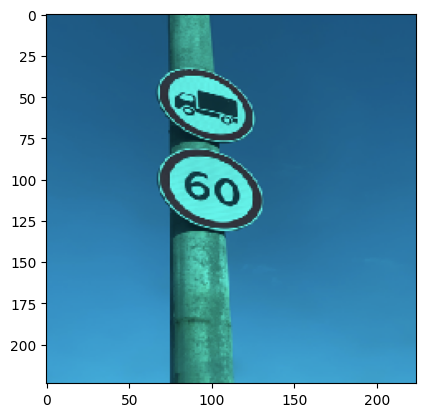

In [10]:
imgplot = plt.imshow(image.astype('uint8'))
print(labels[-1])
print(bboxes[-1])
print(imagePaths[-1])
plt.show()

In [11]:
# normalize -> from [0-255] to [0-1]
data = np.array(data, dtype="float32") / 255.0

# convert to np arrays
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

# one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [13]:
split = train_test_split(data,
                         labels,
                         bboxes,
                         imagePaths,
                         test_size=0.15,
                         random_state=12)


In [14]:
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths,  testPaths)  = split[6:]

# saving test files for later use
with open("testing_multiclass.txt", "w") as f:
    f.write("\n".join(testPaths))

In [15]:
vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
vgg.trainable = False

# max-pooling is output of VGG, flattening it further
flatten = vgg.output
flatten = Flatten()(flatten)

In [17]:
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

In [18]:
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

In [19]:
model = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))

In [20]:
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 16

In [21]:
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

In [22]:
opt = Adam(INIT_LR)

model.compile(loss=losses, 
              optimizer=opt, 
              metrics=["accuracy"], 
              loss_weights=lossWeights)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [23]:
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1)

Epoch 1/25
47/47 [==============================] - 20s 160ms/step - loss: 1.0672 - bounding_box_loss: 0.0221 - class_label_loss: 1.0451 - bounding_box_accuracy: 0.6550 - class_label_accuracy: 0.6940 - val_loss: 0.5830 - val_bounding_box_loss: 0.0236 - val_class_label_loss: 0.5593 - val_bounding_box_accuracy: 0.6970 - val_class_label_accuracy: 0.8030
Epoch 2/25
47/47 [==============================] - 4s 93ms/step - loss: 0.7576 - bounding_box_loss: 0.0131 - class_label_loss: 0.7444 - bounding_box_accuracy: 0.7745 - class_label_accuracy: 0.7570 - val_loss: 0.4604 - val_bounding_box_loss: 0.0229 - val_class_label_loss: 0.4375 - val_bounding_box_accuracy: 0.6818 - val_class_label_accuracy: 0.8409
Epoch 3/25
47/47 [==============================] - 4s 84ms/step - loss: 0.5779 - bounding_box_loss: 0.0090 - class_label_loss: 0.5689 - bounding_box_accuracy: 0.8174 - class_label_accuracy: 0.7987 - val_loss: 0.3846 - val_bounding_box_loss: 0.0215 - val_class_label_loss: 0.3631 - val_bounding_b

In [24]:
model.save("model_bbox_regression_and_classification", save_format="h5")

In [25]:
f = open("lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

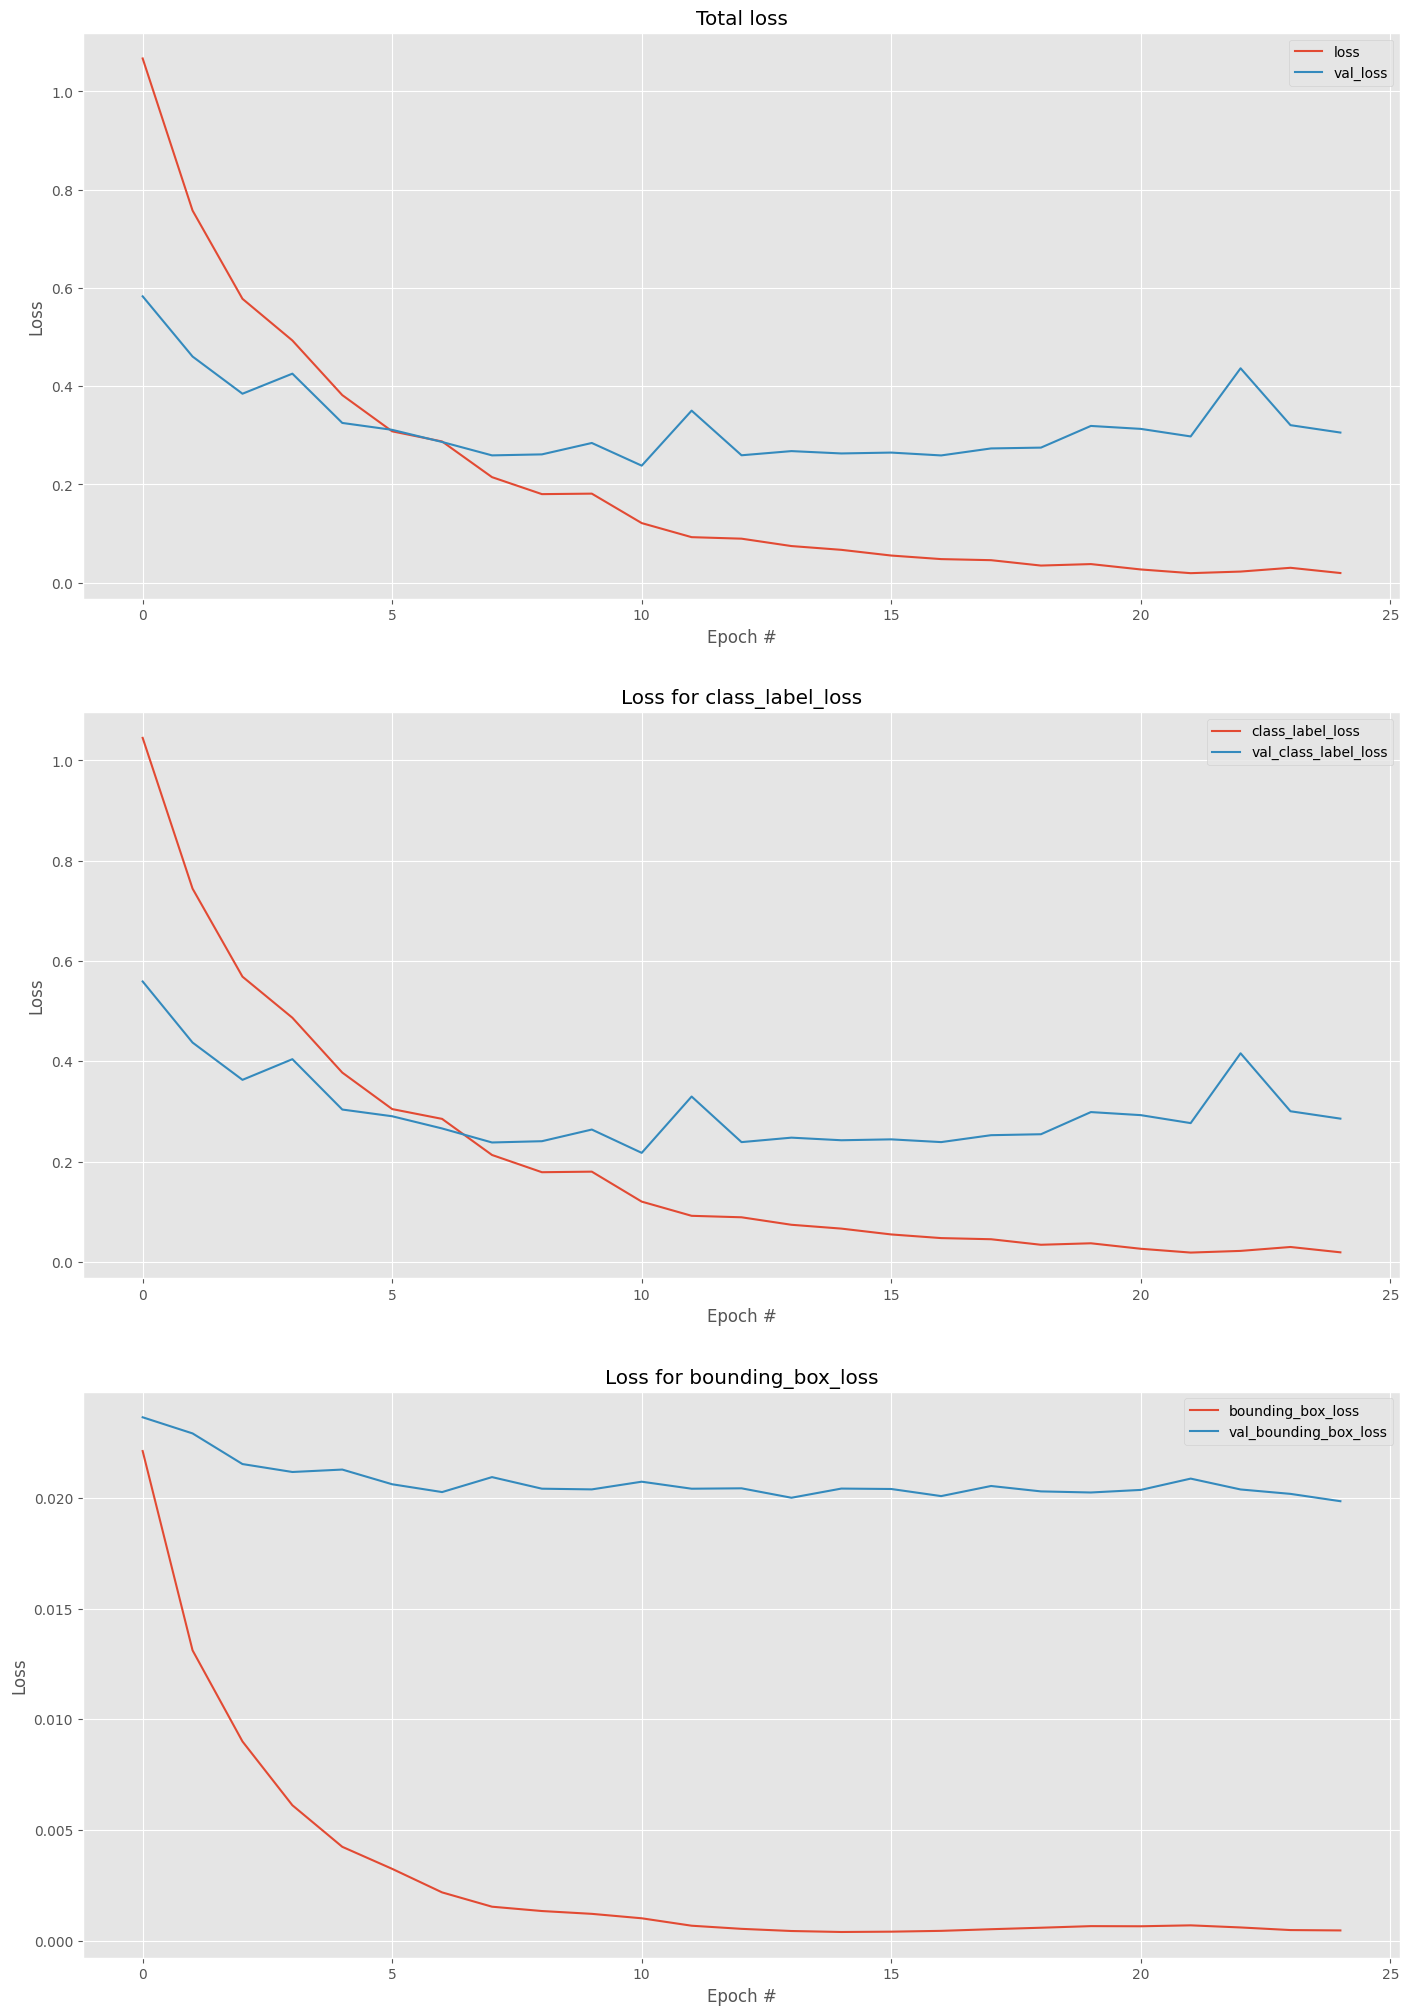

In [26]:
lossNames = ["loss", 
             "class_label_loss", 
             "bounding_box_loss"]

N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(17, 25))

# plotting the loss for training and validation data

for (i, l) in enumerate(lossNames):
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()

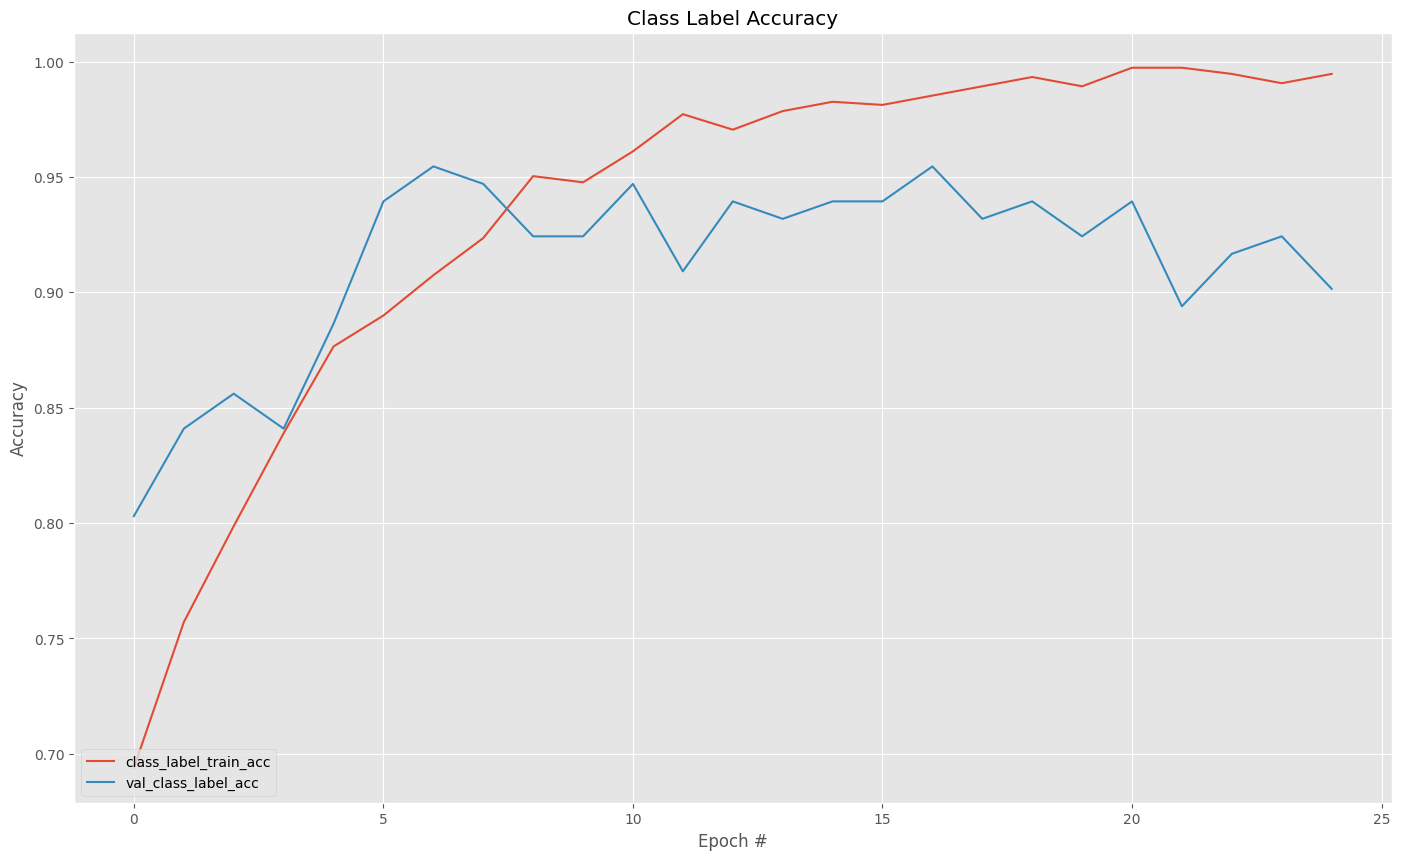

In [27]:
plt.style.use("ggplot")
plt.figure(figsize=(17, 10))

plt.plot(N, H.history["class_label_accuracy"],
         label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
         label="val_class_label_acc")

plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# save the accuracies plot
plotPath = os.path.sep.join(["acc_label.png"])
plt.savefig(plotPath)

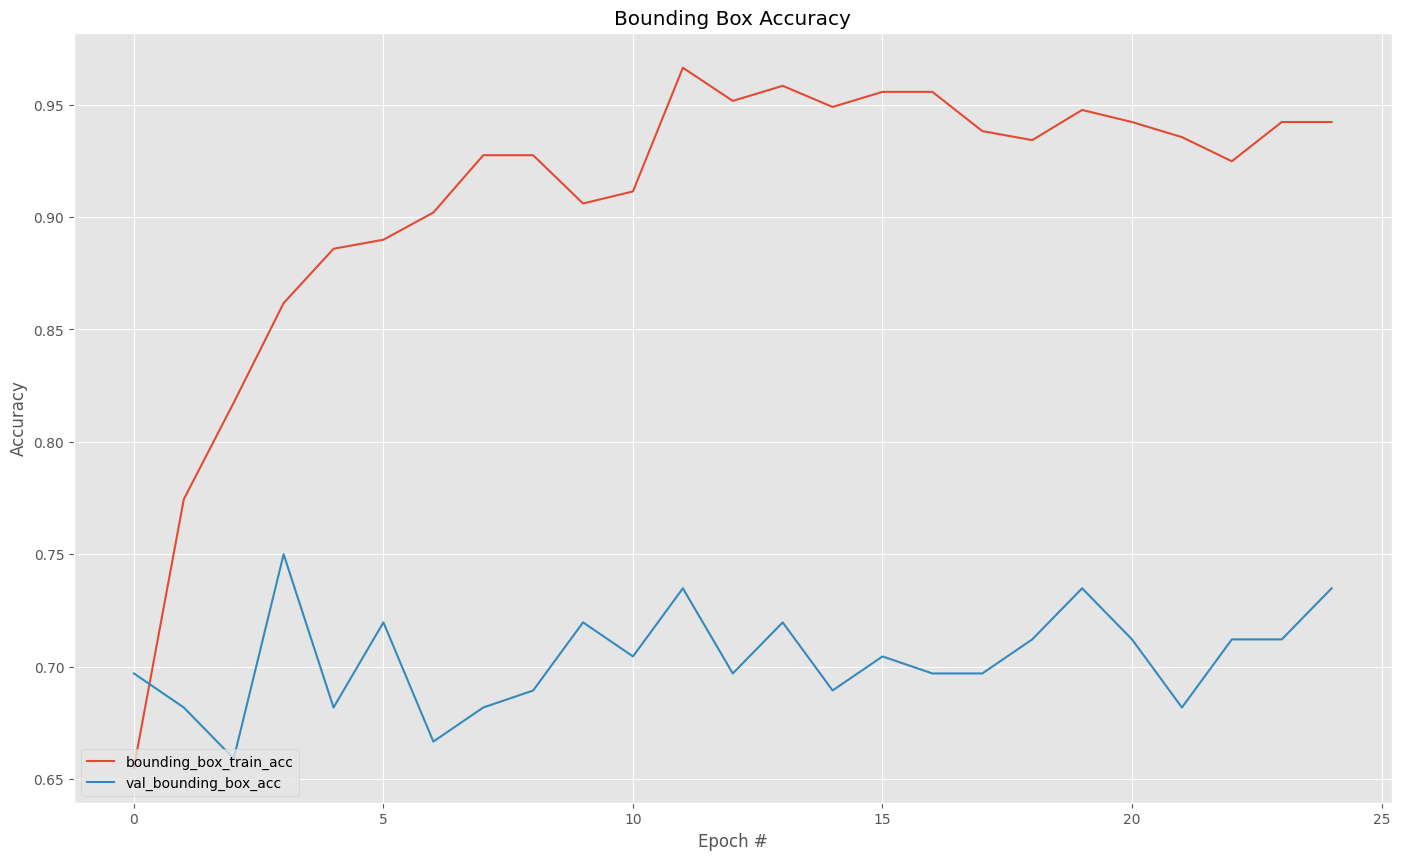

In [28]:
plt.style.use("ggplot")
plt.figure(figsize=(17, 10))

plt.plot(N, H.history["bounding_box_accuracy"],
         label="bounding_box_train_acc")
plt.plot(N, H.history["val_bounding_box_accuracy"],
         label="val_bounding_box_acc")

plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# save the accuracies plot
plotPath = os.path.sep.join(["acc_bbox.png"])
plt.savefig(plotPath)

In [29]:
path = "testing_multiclass.txt"
filenames = open(path).read().strip().split("\n")
imagePaths = []

for f in filenames:
    imagePaths.append(f)

## Testing Sample image dataset.

In [30]:
model = load_model("./model_bbox_regression_and_classification")
lb = pickle.loads(open("./lb.pickle", "rb").read())

1/1 [==============================] - 0s 64ms/step


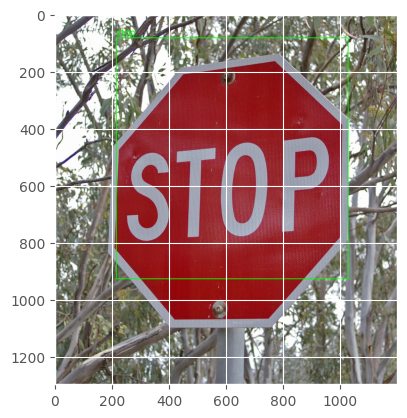

In [33]:
# Testing on image taken randomly from google from Google

    # loading input image
    image = load_img('/content/stop.jpg', target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # predicting bbox and label
    (boxPreds, labelPreds) = model.predict(image)
    (startX, startY, endX, endY) = boxPreds[0]

    # finding class label with highest pred. probability
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]

    # loading the image in OpenCV format
    image = cv2.imread('/content/stop.jpg')
    # image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    # scaling pred. bbox coords according to image dims
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # drawing bbox and label on image
    y = startY - 10 if startY - 10 > 10 else startY + 10

    cv2.putText(image,
                label,
                (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2)

    cv2.rectangle(image,
                  (startX, startY),
                  (endX, endY),
                  (0, 255, 0),
                  2)


    # showing the output image
    imgplot = plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('uint8'))
    plt.show()



1/1 [==============================] - 0s 53ms/step


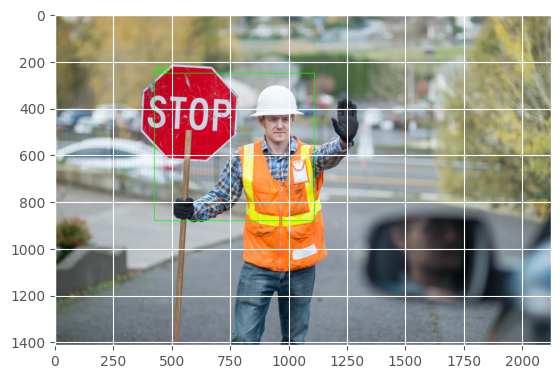

In [34]:

    # loading input image
    image = load_img('/content/stop2.jpg', target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # predicting bbox and label
    (boxPreds, labelPreds) = model.predict(image)
    (startX, startY, endX, endY) = boxPreds[0]

    # finding class label with highest pred. probability
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]

    # loading the image in OpenCV format
    image = cv2.imread('/content/stop2.jpg')
    # image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    # scaling pred. bbox coords according to image dims
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # drawing bbox and label on image
    y = startY - 10 if startY - 10 > 10 else startY + 10

    cv2.putText(image,
                label,
                (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2)

    cv2.rectangle(image,
                  (startX, startY),
                  (endX, endY),
                  (0, 255, 0),
                  2)


    # showing the output image
    imgplot = plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('uint8'))
    plt.show()